# Candidate problem
***
This notebook contains the main steps to solve the candidate problem for Univers Solar Advanced Analytics. The current notebook is divided as follows:
1. **Import main libraries and internally-developed functions**
2. **Read and visualize data set**
3. **Get AC power expected**
4. **Model instantaneous Soiling Ratio**

## 1. Import main libraries and internally-developed functions

### Import general libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns;sns.set_style("whitegrid")
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import sys
import os
import warnings
warnings.filterwarnings('ignore')

### Import internally-developed functions

In [19]:
sys.path.append('D:/repo/Envision_Digital/test/test_2')  # Path to the functions
# import tools
from source import tools, pv_functions, soiling

## 2. Read and visualize data set 

### Read Data
***
Get the data from teh .csv file

In [6]:
# Usage
data_file = r'D:\repo\Envision_Digital\test\test_2\data\data_input.csv'

if os.path.isfile(data_file):
    data_df = tools.read_data(data_file)
    print("Data loaded successfully.")
else:
    print(f"File not found: {data_file}")

# Get the usefull columns
data_df = data_df[['wind_speed', 'tmp_amb', 'poa', 'tmp_cell','ac_power','rain_mm']]

Data loaded successfully.


### Data visualization
***

Make sure that the data is well loaded and in sync

In [7]:
# Define the date for which you want to plot data
target_date = '2021-07-18'  # visualizing only one day

# Filter the DataFrame to include data for the target date
one_day_df = data_df[data_df.index.date == pd.to_datetime(target_date).date()]

# Create a figure with two subplots, sharing the x-axis
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.05)

# Add the first scatter plot for 'poa' on the first subplot
fig.add_trace(go.Scatter(x=one_day_df.index, y=one_day_df['poa'], name='POA'), row=1, col=1)

# Add the second scatter plot for 'ac_power' on the second subplot
fig.add_trace(go.Scatter(x=one_day_df.index, y=one_day_df['ac_power'], name='AC Power'), row=2, col=1)

# Set the axis labels
fig.update_xaxes(title_text='Time', row=2, col=1)
fig.update_yaxes(title_text='Irradiance POA [W/m^2]', row=1, col=1)
fig.update_yaxes(title_text='AC Power [W]', row=2, col=1)

# Set the title for the whole figure
fig.update_layout(title_text=f'POA and AC Power for {target_date}')

fig.show()

## 3. Get AC power expected
***
Expected AC Power = DC-AC Inverter Efficiency * DC Power Rating / G * POA Irradiance * ( 1 – Module temperature coefficient *
(Reference Temperature - Cell temperature) )

    *where G = 1000 W/m^2 and Reference temperature = 25 deg C

In [18]:
# Dataset associated parameters
constants = {
    'Mcoef': -0.0045, # (deg C^-1)
    'DC_P': 80000,  # W
    'AC_P': 70000,  # W
    'Tilt': 15,  # deg
    'Azimuth': 180,  # deg
    'DC_AC_n': 1,  # 100%
    'G': 1000,  # W/m^2
    'Tcell_ref': 25,  # deg C
}

weather_columns = {
    'poa': 'poa',
    'tmp_cell': 'tmp_cell',
    # Add more columns as needed.
}

data_df = pv_functions.calculate_expected_power(data_df, constants, weather_columns)
print('AC Expected power calculated')

AC Expected power calculated


### Visualizing expected values


In [17]:
# Filter the DataFrame to include data for the target date
one_day_df = data_df[data_df.index.date == pd.to_datetime(target_date).date()]
fig = px.scatter(one_day_df, x=one_day_df.index, y='AC_Power_exp', labels={'AC_Power_exp': 'AC Power expected'})
fig.add_scatter(x=one_day_df.index, y=one_day_df['ac_power'], mode='lines+markers', name='AC Power Measured')
# Set the axis labels
fig.update_xaxes(title_text='Time')
fig.update_yaxes(title_text='AC Power [W]')

fig.update_layout(title=f'Power Comparison {target_date}')
fig.show()

## Model instantaneous Soiling Ratio

### Calculate Instantaneous Soiling Ratio

This function computes the Instantaneous Soiling Ratio (SRatio) based on provided data and applies various filters according to https://doi.org/10.1016/j.energy.2022.123173. The SRatio represents the deposition of soiling on solar panels and is computed as the ratio of the actual AC power measured to the reference AC power (measured) under clean conditions (expected conditions-calculated).

#### Calculation of SRatio

The SRatio is calculated as:

\[
\text{SRatio} = \frac{\text{AC Power Measured}}{\text{AC Power Reference}}
\]

#### Filters Applied

The function applies three filters to the data to select the data with quality under certain conditions according to the publication:

1. **Time of Day Filter**: This filter restricts the data to a specific time range between 11 a.m. and 1 p.m. Focus on data collected during periods with the most significant solar irradiance.

2. **Irradiance Threshold Filter**: Data points with Global Plane of Array Irradiance (GPOA) less than 700 W/m² are excluded from the calculation. This step is taken to reduce noise in the soiling extraction process and focus on data collected under sufficient irradiance.

3. **Two-Sigma Filter**: The function calculates the mean (\(\mu\)) and standard deviation (\(\sigma\)) of the SRatio based on the data points that passed the previous filters. Then, it filters the SRatio data to retain values within two standard deviations from the mean:

\[
\text{SRatio} \in [\mu - 2\sigma, \mu + 2\sigma]
\]

The two-sigma filter helps remove outliers and data points that deviate significantly from the typical SRatio values.

#### Output

The function returns a filtered DataFrame containing SRatio values that have passed all applied filters.

#### Usage Example

```python
filtered_df = instantaneous_soiling_ratio(df_rate)


In [24]:
df_rate = soiling.instantaneous_soiling_ratio(data_df)
fig= px.scatter(df_rate, x=df_rate.index, y='S_ratio')
# Set the axis labels
fig.update_xaxes(title_text='Time')
fig.update_yaxes(title_text='Instantaneous soiling rate')

fig.update_layout(title=f'Soiling Rate')
fig.show()

In [ ]:
daily_rate = df_rate[['S_ratio_F3', 'rain_mm']].resample('D').mean()
daily_rate.rain_mm.replace(0, np.nan, inplace=True)
daily_rate

# figure 1

In [ ]:
x = daily_rate.index
fig, axs = plt.subplots(2,1,figsize=(16,9), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)
axs[0].plot(x, daily_rate.S_ratio_F3, marker = '.', markersize = 10)
axs[1].bar(x=x, height=daily_rate.rain_mm, color='red')
axs[1].set_xlabel('Time')
axs[0].set_ylabel('Soiling rate', color='b')
axs[1].set_ylabel('Rain [mm]', color='red')


# Module soiling rate (%/day) for the year --- a single value!


In [ ]:
soiling_rate = 1-daily_rate.S_ratio_F3
# Average daily soiling rate in a year
mean_sr = soiling_rate.mean()
# Plot
fig = px.histogram(soiling_rate, x="S_ratio_F3")
fig.add_vline(x=mean_sr, line_color='red', name='mean')
fig.show()


In [ ]:
print("Soiling rate %.2f" %mean_sr + ' [%/day]')

# Uncertainty in the measured module soiling rate (%/day) --- also a single value!

In [ ]:
soiling_rate = pd.DataFrame(soiling_rate.dropna())
soiling_rate['deviation'] = soiling_rate.S_ratio_F3 - mean_sr
soiling_rate['squared'] = soiling_rate['deviation']**2

In [ ]:
# Uncertainty (from https://www.educba.com/uncertainty-formula/)
l = len(soiling_rate.squared)
total_s = soiling_rate.squared.sum()
import math 
Uncertainty = math.sqrt(total_s/(l*(l-1)))
print('Uncertainty %.3f'%Uncertainty + ' [%/day]')

In [ ]:
# Meaning that 
a = 2 * Uncertainty
print("Soiling rate at 95perc confidence level is %.2f" %mean_sr + ' +- %.3f' %a + ' [%/day]')


# Lost energy due to soiling (kWh)

In [ ]:
losses_df = df.copy()
# Converting 5 min W to Wh
losses_df['energy_ref'] = .08333 * losses_df['AC_Power_ref']
# Getting daily Wh values
daily_energy = losses_df[['energy_ref']].resample('D').sum()
daily_energy['energy_with_losses'] = (1- mean_sr) * daily_energy['energy_ref']
daily_energy['total_losses'] = daily_energy['energy_ref'] - daily_energy['energy_with_losses']

In [ ]:
total_losses = daily_energy['total_losses'].sum()/1000
print('Total losses = %.2f [kWh]' %total_losses)

# Non-rain wash event date (there is only one!)

From figure 1, we can observe that there is only one moment when there is no rain but the Soiling rate recovers. Due to that, we can say that the event when the panels where cleaned was in the month of **Semptember**.

# BONUS: Where in the world is this module located? (Only address this question if you’ve provided valid answers for #1-4)

From the timestamps we can see that the local time is UTC-7 therefore, the PV system can be located in Mountain Standard Time (MST) in North America (in green):


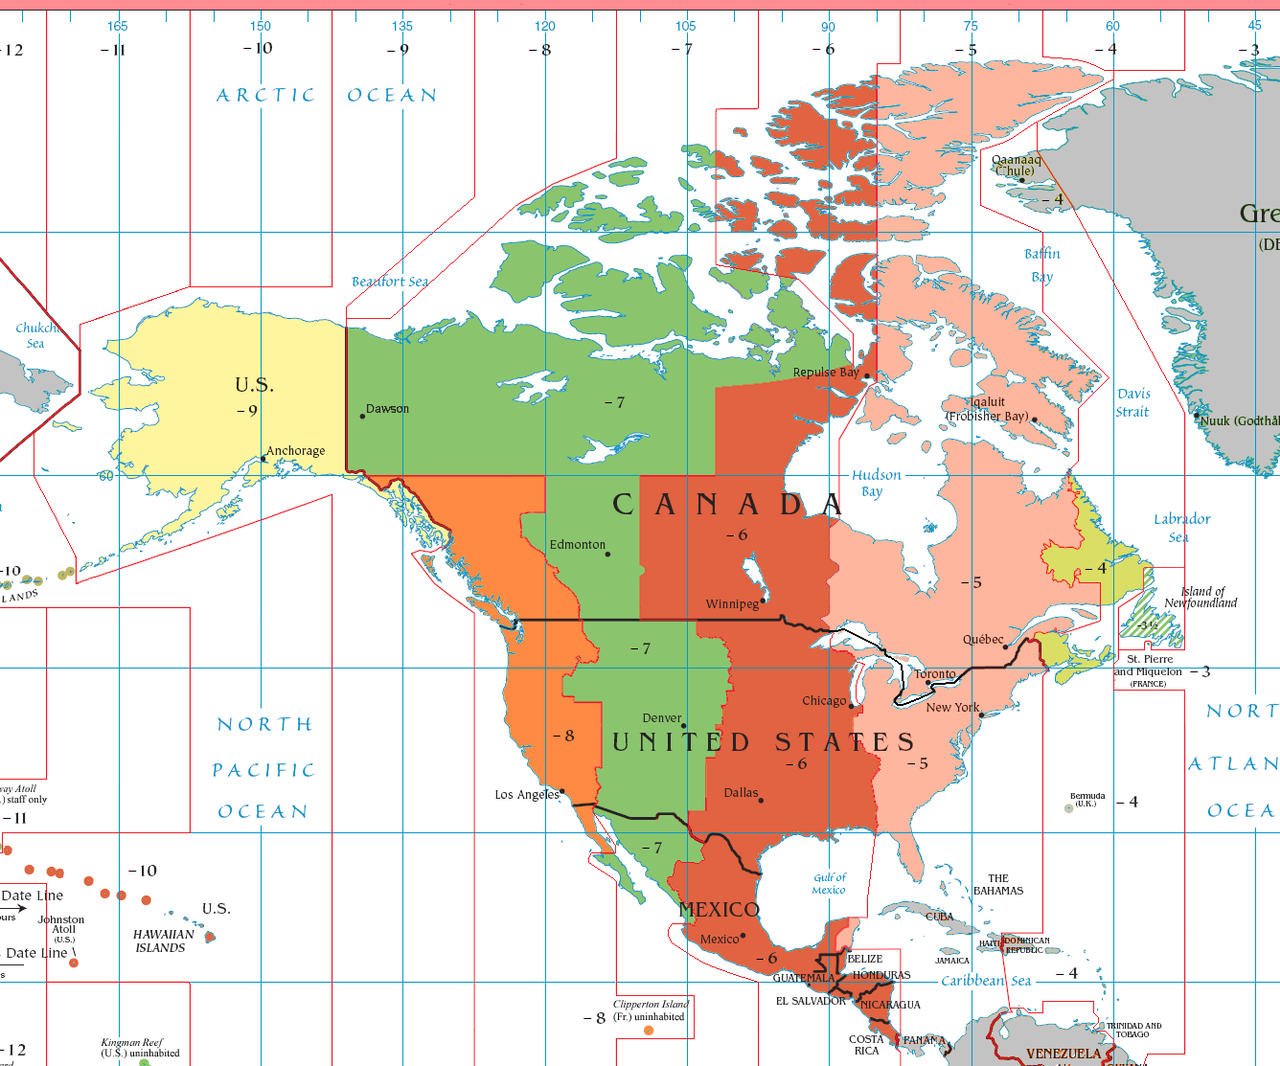